## Partial Differential Equations

A partial differential equation is a set of conditions (derivatives, boundaries, initial) on a function of two or more variables. For example, the heat (or diffusion) equation is 

$$ u_t = k u_{xx}.$$

This is an example of a parabolic partial differential equation. For the definition (a constraint on the coefficients of $u_{xx}$, $u_{tx}$ and $u_{tt}$) see [Wikipedia](https://en.wikipedia.org/wiki/Parabolic_partial_differential_equation).

To solve the equation you also need to describe

* the value of any constants, $k=1$,
* the domain $0 \leq x \leq 1$, $0 \leq t$,
* the boundary conditions $u(t,0) = u(t,1) = 0$, and
* the initial conditions $u(0, x) = \sin(\pi x)$.

### Method of lines

We will solve this problem by discretizing space ($x$) and solving a set of initial value problems.

For the boundary and initial conditions described above, we want to find a numerical solution for future time $t$.

A useful simplification is to "get rid of" boundary conditions by imposing periodic boundary conditions. If the domain is $[0, L]$ this means that $u(t, x) = u(t, x+L)$.

As with BVPs we will solve for $u$ at a set of discrete nodes, $x_k$, by discretizing the $u_{xx}$ term. We need a slightly different differentiation matrix than before to account for the periodic boundary conditions. We can use centred differences at the first and last node, by wrapping the domain around a circle.

In [2]:
"""
    diffper(n,xspan)

Construct 2nd-order differentiation matrices for functions with
periodic end conditions, using `n` unique nodes in the interval
`xspan`. Returns a vector of nodes and the matrices for the first
and second derivatives.
"""
function diffper(n,xspan)
    a,b = xspan
    h = (b-a)/n
    x = @. a + h*(0:n-1)   # nodes, omitting the repeated data

    # Construct Dx by diagonals, then correct the corners.
    dp = fill(0.5/h,n-1)        # superdiagonal
    dm = fill(-0.5/h,n-1)       # subdiagonal
    Dx = diagm(-1=>dm,1=>dp)
    Dx[1,n] = -1/(2*h)
    Dx[n,1] = 1/(2*h)

    # Construct Dxx by diagonals, then correct the corners.
    d0 =  fill(-2/h^2,n)        # main diagonal
    dp =  ones(n-1)/h^2         # superdiagonal and subdiagonal
    Dxx = diagm(-1=>dp,0=>d0,1=>dp)
    Dxx[1,n] = 1/(h^2)
    Dxx[n,1] = 1/(h^2)

    return x,Dx,Dxx
end

diffper

In [3]:
using LinearAlgebra, LaTeXStrings, Plots
x, D1, D2 = diffper(8, (0,1))
D1

8×8 Matrix{Float64}:
  0.0   4.0   0.0   0.0   0.0   0.0   0.0  -4.0
 -4.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0
  0.0  -4.0   0.0   4.0   0.0   0.0   0.0   0.0
  0.0   0.0  -4.0   0.0   4.0   0.0   0.0   0.0
  0.0   0.0   0.0  -4.0   0.0   4.0   0.0   0.0
  0.0   0.0   0.0   0.0  -4.0   0.0   4.0   0.0
  0.0   0.0   0.0   0.0   0.0  -4.0   0.0   4.0
  4.0   0.0   0.0   0.0   0.0   0.0  -4.0   0.0

We can now solve $u_t = u_{xx}$ as $\frac{du}{dt} = D_{xx} u$.

We can use Euler steps, but we will see that this solution is unstable. Implicit (backwards) Euler will solve the problem. We will use $\tau$ as a time step size:

$$u_{j+1} = u_j + \tau D_{xx} u_j = u_j (I + \tau D_{xx}).$$

We will use an initial condition of a peak in the middle of the interval on the x-axis. This function is not quite periodic (the derivatives at the left and right endpoints are close to zero, but opposite in sign.

We will have 100 divisions of the space axis and 2400 time steps.

In [4]:
m = 100
x,Dx,Dxx = diffper(m,[0,1]);

tfinal = 0.16;  n = 2400;  
τ = tfinal/n;  t = τ*(0:n);

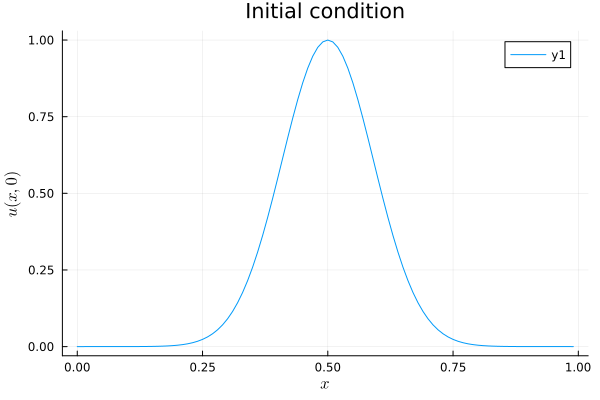

In [5]:
U = zeros(m,n+1);
U[:,1] = @. exp( -60*(x-0.5)^2 )
plot(x,U[:,1],xaxis=(L"x"),yaxis=(L"u(x,0)"),
    title="Initial condition")

We solve the PDE by matrix multiplication.

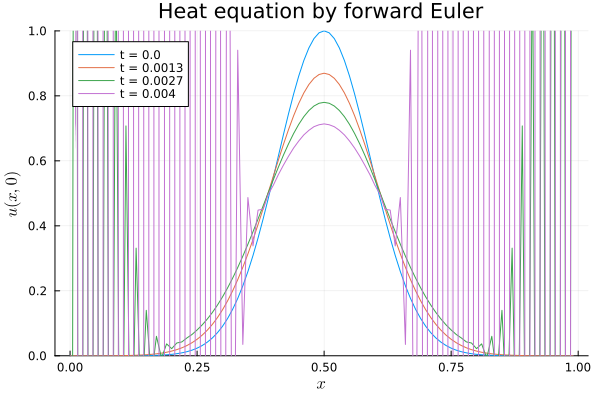

In [6]:
A = I + τ * Dxx # sparse(I+τ*Dxx)
for j in 1:n
    U[:,j+1] = A*U[:,j]
end

idx = [1,21,41,61]
times = round.(t[idx],digits=4)
label = reshape(["t = $t" for t in times],1,length(idx))
plot(x,U[:,idx];label,
    title="Heat equation by forward Euler",legend=:topleft,  
    xaxis=(L"x"),yaxis=(L"u(x,0)",[0,1]))

Since we have two dimensions (time and space), it's natural to want to make an animation instead of looking at time slices.

Easy to do.

In [7]:
using Printf
anim = @animate for j in 1:101
    plot(x,U[:,j], label = @sprintf("t=%.5f",t[j]),
    xaxis=(L"x"),yaxis=(L"u(x,t)",[-1,3]),dpi=100,
    title="Heat equation by forward Euler")
end
mp4(anim,"diffusionFE.mp4")

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionFE.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionFE.mp4")

Backwards Euler is a small change:

$$u_{j+1} = u_j + D_{xx} u_{j+1}$$ 

which can be rewritten as 

$$(I - D_{xx})u_{j+1} = u_j$$

so we need to solve a linear system at each time step.

In [8]:
B = I-τ*Dxx
B_lu = lu(B)
for j in 1:n
    U[:,j+1] = B_lu \ U[:,j]
end

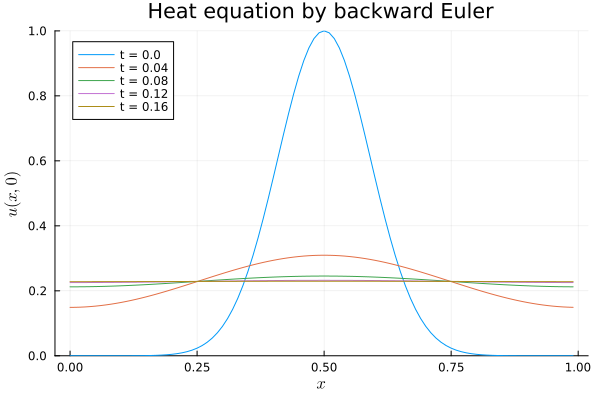

In [9]:
idx = 1:600:n+1
times = round.(t[idx],digits=4)
label = reshape(["t = $t" for t in times],1,length(idx))
plot(x,U[:,idx];label,
    title="Heat equation by backward Euler",legend=:topleft,  
    xaxis=(L"x"),yaxis=(L"u(x,0)",[0,1]))

In [10]:
anim = @animate for j in 1:20:n+1
    plot(x,U[:,j],label=@sprintf("t=%.5f",t[j]),
    xaxis=(L"x"),yaxis=(L"u(x,t)",[0,1]),dpi=100,
    title="Heat equation by backward Euler")
end
mp4(anim,"diffusionBE.mp4")

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionBE.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionBE.mp4")

Not too exciting, but not obviously wrong and unstable either!

Normally you'll want to use something fancier than implicit Euler. The routines in the DifferentialEquations package are perfect for the purpose.

In [11]:
using DifferentialEquations

In [12]:
m = 100
x,Dx,Dxx = diffper(m,[0,1])
u0 = @. exp(-60*(x-0.5)^2);
tfinal = 0.25
ODE = (u,p,t) -> Dxx*u;  
IVP = ODEProblem(ODE,u0,(0,tfinal))
u = solve(IVP, Rodas4P());
println("Number of time steps for Rodas4P: $(length(u.t)-1)")

Number of time steps for Rodas4P: 23


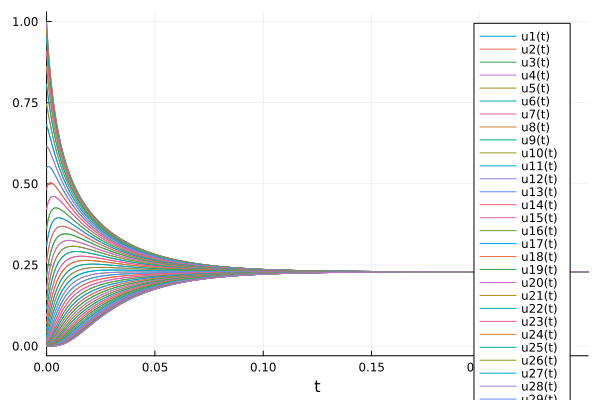

In [13]:
plot(u)

The plot function puts $t$ on the horizontal axis, not $x$. Requires some mental gymnastics to interpret.

In [14]:
times = 0:0.001:0.16
anim = @animate for tk in times
    plot(x, u(tk),label=@sprintf("t=%.5f", tk),
    xaxis=(L"x"), yaxis=(L"u(x,t)", [0,1]), dpi=100,
    title="Heat equation by Rodas4P")
end
mp4(anim,"diffusionBE.mp4")

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionBE.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionBE.mp4")

**Exercise 5**. Solve $u_t = 4u + u_{xx}$. This problem has exponential growth and diffusion.

In [22]:
ODE = (u,p,t) -> 4*(1 .- x) + Dxx*u;  
IVP = ODEProblem(ODE,u0,(0,tfinal))
u = solve(IVP, Rodas4P());

In [23]:
times = 0:0.001:0.16
anim = @animate for tk in times
    plot(x, u(tk),label=@sprintf("t=%.5f", tk),
    xaxis=(L"x"), yaxis=(L"u(x,t)", [0,1]), dpi=100,
    title="Exercise 5 equation by Rodas4P")
end
mp4(anim,"diffusionBE.mp4")

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionBE.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/diffusionBE.mp4")

## Other boundary conditions

For problems with boundary conditions that are not periodic, we can adapt the methods of the BVP solver.

We will use

* Chebyshev nodes,
* PDE method above for the interior nodes,
* Levenberg solver to satisfy the non-linear equations at the boundary.

In [29]:
include("fnc.jl")

bvp

In [27]:
"""
    parabolic(ϕ,xspan,m,g₁,g₂,tspan,init)

Solve a parabolic PDE by the method of lines. The PDE is 
∂u/∂t = `ϕ`(t,x,u,∂u/∂x,∂^2u/∂x^2), `xspan` gives the space 
domain, m gives the degree of a Chebyshev spectral discretization, 
`g₁` and `g₂` are functions of (u,∂u/∂x) at the domain ends that 
should be made zero, `tspan` is the time domain, and `init` is a 
function of x that gives the initial condition. Returns a vector
`x` and a function of t that gives the semidiscrete solution at `x`. 
"""
function parabolic(ϕ,xspan,m,g₁,g₂,tspan,init)
    x,Dₓ,Dₓₓ = diffcheb(m,xspan)
    int = 2:m    # indexes of interior nodes

    function extend(v)
        function objective(ubc)
            u₀,uₘ = ubc
            uₓ = Dₓ*[u₀;v;uₘ]
            return [g₁(u₀,uₓ[1]),g₂(uₘ,uₓ[end])]
        end
        ubc = levenberg(objective,[0,0])[end]
        return [ubc[1];v;ubc[2]]
    end

    function ode!(f,v,p,t)
        u = extend(v)
        uₓ,uₓₓ = Dₓ*u,Dₓₓ*u
        @. f = ϕ(t,x[int],u[int],uₓ[int],uₓₓ[int])
    end

    ivp = ODEProblem(ode!,init.(x[int]),float.(tspan))
    u = solve(ivp)

    return x,t->extend(u(t))
end

parabolic

Here's the heat (diffusion) equation on $[-1, 1]$ with boundary conditions $u(-1)=0$ and $u(1) = 2$. (We don't need to solve a non-linear sytem for this, so our function above does some unnecessary work.)

In [24]:
ϕ = (t,x,u,uₓ,uₓₓ) -> uₓₓ
g₁ = (u,uₓ) -> u
g₂ = (u,uₓ) -> u-2;

Write an initial condition that satisfies the boundary conditions. No other restrictions.

In [25]:
init = x -> x + 1 + sin(π*x*4) + 3*(1-x^2)*exp(-4x^2);

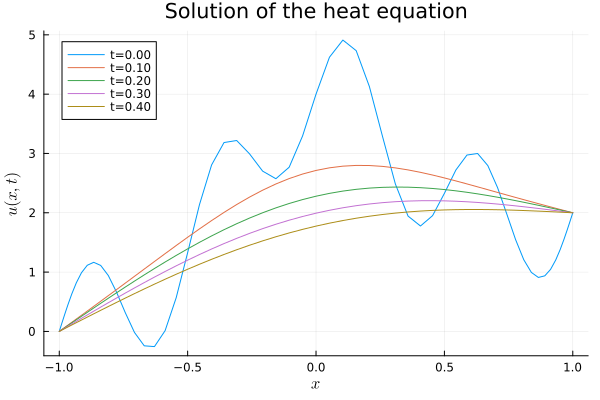

In [30]:
x,u = parabolic(ϕ, (-1,1), 60, g₁, g₂, (0,0.75), init)
plt = plot(xlabel=L"x", ylabel=L"u(x,t)", legend=:topleft,
          title="Solution of the heat equation")
for t in 0:0.1:0.4
    plot!(x,u(t),label=@sprintf("t=%.2f",t))
end
plt

In [31]:
anim = @animate for t in range(0, 0.75, length=201) 
    plot(x, u(t), label=@sprintf("t=%.2f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)", (0,4.2)), 
        title="Heat equation", leg=:topleft, dpi=100)
end
mp4(anim,"boundaries-heat.mp4", fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-heat.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-heat.mp4")

This is a powerful tool we've developed. We can easily change the problem.

In [64]:
ϕ = (t,x,u,uₓ,uₓₓ) -> u^2 + uₓₓ
g₁ = (u,uₓ) -> u
g₂ = (u,uₓ) -> uₓ
init = x -> 400x^4*(1-x)^2
x,u = parabolic(ϕ, (0,1), 60, g₁, g₂, (0,0.1), init);

In [65]:
anim = @animate for t in range(0,0.1,length=101) 
    plot(x,u(t),label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(0,10)),dpi=100, 
        title="Heat equation with source",leg=:topleft)
end
mp4(anim,"boundaries-source.mp4",fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-source.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-source.mp4")

Here is a famous stock-market options pricing model (Black-Scholes equation) from Section 11.1.

In [66]:
K = 3;  σ = 0.06;  r = 0.08;  Smax = 8;
ϕ = (t,x,u,uₓ,uₓₓ) -> σ^2/2*(x^2*uₓₓ) + r*x*uₓ - r*u
g₁ = (u,uₓ) -> u
g₂ = (u,uₓ) -> uₓ-1;

In [67]:
u₀ = x -> max(0,x-K)
x,u = parabolic(ϕ,(0,Smax),80,g₁,g₂,(0,15),u₀);

In [68]:
anim = @animate for t in range(0,15,length=151) 
    plot(x,u(t),label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(-0.5,8)),dpi=100, 
        title="Black–Scholes equation",leg=:topleft)
end
mp4(anim,"boundaries-bs.mp4",fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-bs.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-bs.mp4")

There are additional interesting examples in the exercises. Here is question 11.5.4.

In [78]:
ϵ = 1e-3
β = 1.1
ϕ = (t,x,u,uₓ,uₓₓ) -> u*(1-u^2) + ϵ * uₓₓ
g₁ = (u,uₓ) -> u + 1
g₂ = (u,uₓ) -> u + 1;
u0 = x -> -1 + β * (1-x^2)*exp(-20*x^2)
x, u = parabolic(ϕ, (-1, 1), 199, g₁, g₂, (0, 8), u0);

In [79]:
anim = @animate for t in range(0, 8, length=151) 
    plot(x, u(t), label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(-1,1)),dpi=100, 
        title="Q 11.5.4 β = 1.1",leg=:topleft)
end
mp4(anim,"boundaries-bs.mp4",fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-bs.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-bs.mp4")

If β is larger, a different result develops.

In [77]:
β = 1.6
x, u = parabolic(ϕ, (-1, 1), 199, g₁, g₂, (0, 8), u0);
anim = @animate for t in range(0, 8, length=151) 
    plot(x, u(t), label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(-1,1)),dpi=100, 
        title="Q 11.5.4 β = 1.6",leg=:topleft)
end
mp4(anim,"boundaries-bs.mp4",fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-bs.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/boundaries-bs.mp4")

## Additional Julia packages

Here are examples to two other ways to solve the heat equation with Julia packages.


## Example 1

Method of lines from symbolic equations. Library code discretizes the equations and solves the IVPs, satisfying the IC and BC. You just write the equations and call the methods.

https://docs.sciml.ai/MethodOfLines/stable/tutorials/heat/

The libraries take a long time to load (compile), but after you've done that once the system can be solved in less than 0.003 s.

  0.002427 seconds (6.19 k allocations: 419.414 KiB)


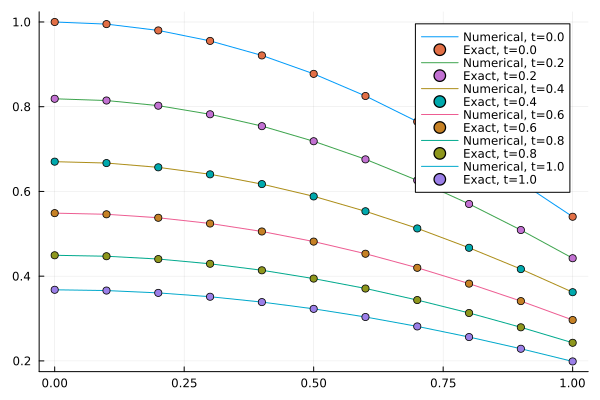

In [119]:
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets
# Method of Manufactured Solutions: exact solution
u_exact = (x,t) -> exp.(-t) * cos.(x)

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dxx = Differential(x)^2

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ Dxx(u(t, x))
bcs = [u(0, x) ~ cos(x),
        u(t, 0) ~ exp(-t),
        u(t, 1) ~ exp(-t) * cos(1)]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.1
order = 2
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys,discretization)

# Solve ODE problem
using OrdinaryDiffEq
@time sol = solve(prob, Tsit5(), saveat=0.2)

# Plot results and compare with exact solution
discrete_x = sol[x]
discrete_t = sol[t]
solu = sol[u(t, x)]

using Plots
plt = plot()

for i in 1:length(discrete_t)
    plot!(discrete_x, solu[i, :], label="Numerical, t=$(discrete_t[i])")
    scatter!(discrete_x, u_exact(discrete_x, discrete_t[i]), label="Exact, t=$(discrete_t[i])")
end
display(plt)

In [113]:
sol(0.5, discrete_x)

1-element Vector{Vector{Float64}}:
 [0.6095658410648329, 0.606575456786095, 0.5973932891369345, 0.5824767644777467, 0.561406267545973, 0.5351086004775869, 0.5030534070145842, 0.4663544013578841, 0.4246629697810246, 0.37896409623143334, 0.3293498295057812]

In [116]:
anim = @animate for t in range(0, 1, length = 120)
    plot(discrete_x, sol(t, discrete_x), label=@sprintf("t=%.4f", t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(0,1.1)),dpi=100, 
        leg=:topleft)
end
mp4(anim,"temp.mp4",fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/temp.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/temp.mp4")

Solve another problem.

  0.018688 seconds (80.51 k allocations: 4.688 MiB)


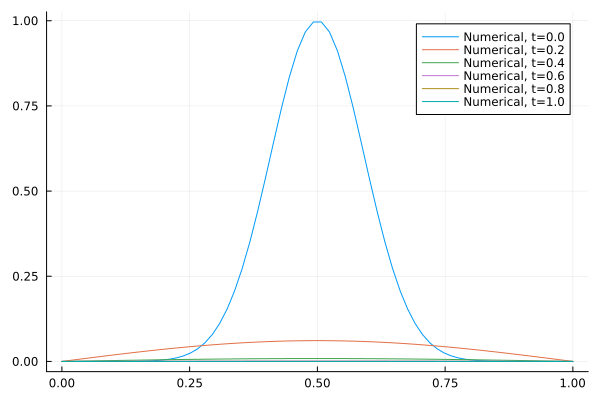

In [134]:
# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ Dxx(u(t, x))
bcs = [u(0, x) ~ exp(-60*(x-0.5)^2),
       u(t, 0) ~ 0,
       u(t, 1) ~ 0 ]

@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# uniform discretization
# dx = 0.01
# order = 2
# discretization = MOLFiniteDifference([x => dx], t)
# prob = discretize(pdesys,discretization)
# @time sol = solve(prob, Tsit5(), saveat=0.2)

# Chebyshev discretization
discx = chebyspace(100, domains[2]) # 100 point Chebyshev space, pair `x => points`
discretization = MOLFiniteDifference([discx], t)
prob = discretize(pdesys,discretization)
@time sol = solve(prob, Rodas4P(), saveat = 0.2)

discrete_x = sol[x]
discrete_t = sol[t]
solu = sol[u(t, x)]

plt = plot()
for i in 1:length(discrete_t)
    plot!(discrete_x, solu[i, :], label="Numerical, t=$(discrete_t[i])")
end
display(plt)

In [135]:
anim = @animate for t in range(0, 1, length = 120)
    plot(discrete_x, sol(t, discrete_x), label=@sprintf("t=%.4f", t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(0,1.1)),dpi=100, 
        leg=:topleft)
end
mp4(anim,"temp.mp4",fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/temp.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/temp.mp4")

### Example 2

This is an old method and will disappear at some point.

https://github.com/SciML/DiffEqOperators.jl

Heat Equation. This example demonstrates how to combine `OrdinaryDiffEq` with `DiffEqOperators` to solve a time-dependent PDE. We consider the heat equation on the unit interval, with Dirichlet boundary conditions:
* ∂ₜu = Δu
* u(x=0,t)  = a
* u(x=1,t)  = b
* u(x, t=0) = u₀(x)


In [93]:
using DiffEqOperators, OrdinaryDiffEq

# For `a = b = 0` and `u₀(x) = sin(2πx)` a solution is given by:
u_analytic(x, t) = sin(2*π*x) * exp(-t*(2*π)^2)

nknots = 100
h = 1.0/(nknots+1)
knots = range(h, step=h, length=nknots)
ord_deriv = 2
ord_approx = 2

const Δ = CenteredDifference(ord_deriv, ord_approx, h, nknots)
const bc = Dirichlet0BC(Float64)

t0 = 0.0
t1 = 0.05
u0 = u_analytic.(knots, t0)

step(u,p,t) = Δ*bc*u
prob = ODEProblem(step, u0, (t0, t1))
alg = KenCarp4()
sol = solve(prob, alg)

retcode: Success
Interpolation: 3rd order Hermite
t: 4-element Vector{Float64}:
 0.0
 0.008958117052274693
 0.03546033979454778
 0.05
u: 4-element Vector{Vector{Float64}}:
 [0.062169637431480525, 0.12409875261325934, 0.18554775382949323, 0.24627890683200135, 0.30605725458788735, 0.3646515262826551, 0.4218350320620623, 0.477386540051127, 0.531091132257275, 0.5827410360463009  …  -0.5827410360463008, -0.5310911322572754, -0.47738654005112713, -0.4218350320620621, -0.3646515262826555, -0.3060572545878882, -0.24627890683200196, -0.18554775382949354, -0.12409875261325934, -0.06216963743148109]
 [0.043655672940642834, 0.08714245056354317, 0.13029209097413208, 0.1729376565962203, 0.21491416002105007, 0.25605920231152807, 0.2962136012921642, 0.33522200739398444, 0.37293350467183445, 0.4092021946688525  …  -0.4092021946688513, -0.3729335046718334, -0.33522200739398356, -0.2962136012921634, -0.25605920231152746, -0.21491416002104957, -0.1729376565962199, -0.1302920909741318, -0.087142450563543, 

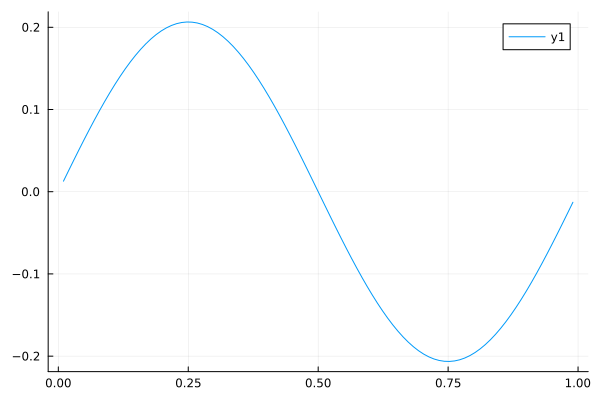

In [94]:
plot(knots, sol(0.04))

In [95]:
anim = @animate for t in range(0, 0.05, length=151) 
    plot(knots, sol(t), label=@sprintf("t=%.4f",t),
        xaxis=(L"x"), yaxis=(L"u(x,t)",(-1,1)),dpi=100, 
        leg=:topleft)
end
mp4(anim,"temp.mp4",fps=30)

[ Info: Saved animation to /Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/temp.mp4


Plots.AnimatedGif("/Users/airwin/Dropbox/Teaching/M3210 Numerical Analysis/2023W/notebooks/temp.mp4")